In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy
import time

In [2]:
class Linear(nn.Module):
    def __init__(self, C_syn_e, C_syn_i, T_no, device):
        super().__init__()
        
        self.sub_no = C_syn_e.shape[0]
        self.C_syn_e = C_syn_e
        self.C_syn_i = C_syn_i
        self.T_no = T_no
        self.E_no = C_syn_e.shape[1]
        self.I_no = C_syn_i.shape[1]
        self.device = device
        
        self.E_scale = nn.Parameter(torch.zeros(self.E_no))
        self.I_scale = nn.Parameter(torch.zeros(self.I_no))
        
        self.cos_basis_no = 30
        self.scale = 7.5
        self.shift = 1
        
        self.kern_basis = torch.zeros(self.cos_basis_no, T_no).to(device)
        for i in range(self.cos_basis_no):
            phi = 1.5707963267948966*i
            xmin = phi - 3.141592653589793
            xmax = phi + 3.141592653589793

            x_in = torch.arange(0, T_no, 1)
            raw_cos = self.scale  * torch.log(x_in + self.shift + 1e-7)

            basis = 0.5*torch.cos(raw_cos - phi) + 0.5
            basis[raw_cos < xmin] = 0.0
            basis[raw_cos > xmax] = 0.0
            self.kern_basis[i] = basis
        
        self.W_e = nn.Parameter(torch.randn(self.sub_no , self.cos_basis_no)*0.01)        
        self.W_i = nn.Parameter(torch.randn(self.sub_no , self.cos_basis_no)*0.01)
        self.V_o = nn.Parameter(torch.zeros(1))
    
    def forward(self, S_e, S_i):
        # S is (batch, T, E)
        T_data = S_e.shape[1]
        batch = S_e.shape[0]

        S_e = S_e * torch.exp(self.E_scale.reshape(1,1,-1))
        S_i = S_i * torch.exp(self.I_scale.reshape(1,1,-1))
        syn_e = torch.matmul(S_e, self.C_syn_e.T.unsqueeze(0))
        syn_i = torch.matmul(S_i, self.C_syn_i.T.unsqueeze(0))

        pad_syn_e = torch.zeros(batch, T_data + self.T_no-1, self.sub_no).to(self.device)
        pad_syn_i = torch.zeros(batch, T_data + self.T_no-1, self.sub_no).to(self.device)
        pad_syn_e[:,-T_data:] = pad_syn_e[:,-T_data:] + syn_e
        pad_syn_i[:,-T_data:] = pad_syn_i[:,-T_data:] + syn_i
        pad_syn_e = pad_syn_e.permute(0,2,1)
        pad_syn_i = pad_syn_i.permute(0,2,1)
        
        layer1_e_kern = torch.matmul(self.W_e, self.kern_basis) # (sub*H, T_no)
        layer1_i_kern = torch.matmul(self.W_i, self.kern_basis) # (sub*H, T_no)
        layer1_e_kern = torch.flip(layer1_e_kern, [1]).unsqueeze(1)
        layer1_i_kern = torch.flip(layer1_i_kern, [1]).unsqueeze(1)
        
        layer1_e_conv = F.conv1d(pad_syn_e, layer1_e_kern, groups=self.sub_no)
        layer1_i_conv = F.conv1d(pad_syn_i, layer1_i_kern, groups=self.sub_no)
        layer1_out = layer1_e_conv + layer1_i_conv + self.V_o
        
        return layer1_out

In [3]:
sub_no = 10
E_no = 2000
I_no = 200
T_no = 500
device = torch.device("cuda")

base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"

V = np.load("/media/hdd01/sklee/CA1_clust4-60/hand/gru_s10_h20_output.npz")["sub_out"]
V = torch.from_numpy(V)
V_train = V[:19].float().to(device)
V_test = V[-1].float().to(device)

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)

C_syn_e = np.load("/media/hdd01/sklee/CA1_clust4-60/data/handsub10_C_syn_e.npy")
C_syn_i = np.load("/media/hdd01/sklee/CA1_clust4-60/data/handsub10_C_syn_i.npy")
C_syn_e = torch.from_numpy(C_syn_e).float()
C_syn_i = torch.from_numpy(C_syn_i).float()

In [4]:
train_E_neural = E_neural[-20*50000:-1*50000].toarray().reshape(19,50000,2000)
train_I_neural = I_neural[-20*50000:-1*50000].toarray().reshape(19,50000,200)
test_E_neural = E_neural[-1*50000:].toarray().reshape(1,50000,2000)
test_I_neural = I_neural[-1*50000:].toarray().reshape(1,50000,200)

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)
train_E_neural = torch.from_numpy(train_E_neural)
train_I_neural = torch.from_numpy(train_I_neural)

train_idx = np.empty((1000, 19))
for i in range(1000):
    part_idx = np.arange(19)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx).long()

In [5]:
model = Linear(C_syn_e.to(device), C_syn_i.to(device), T_no, device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.005/(1**100))

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

2801


In [6]:
score_list = []

#for i in tnrange(iter_no):
for i in tnrange(10000):
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i*5:(i+1)*5]
    batch_E_neural = train_E_neural[batch_idx].float().to(device)
    batch_I_neural = train_I_neural[batch_idx].float().to(device)
    batch_V = V_train[batch_idx]
    
    V_pred = model(batch_E_neural, batch_I_neural)
    
    loss = torch.mean((V_pred - batch_V)**2)
    loss.backward()
    optimizer.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred = model(test_E_neural, test_I_neural)
                 
        test_mse = torch.mean((V_test-test_V_pred.squeeze(0))**2).item()
        score_list.append(test_mse)
                
        print(i, np.round(test_mse,6))


<ipython-input-6-c90aa0cc275f>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(10000):


  0%|          | 0/10000 [00:00<?, ?it/s]

0 0.092146
49 0.012022
99 0.010968
149 0.010097
199 0.009191
249 0.008643
299 0.008591
349 0.008516
399 0.00853
449 0.008531
499 0.008546
549 0.008533
599 0.00858
649 0.008545


KeyboardInterrupt: 

In [7]:
print(V_test.shape)

torch.Size([10, 50000])


In [8]:
print(test_V_pred.shape)

torch.Size([1, 10, 50000])


In [11]:
final_test = np.zeros((8,3,30,6000))

syn_list = [821, 580, 1211, 692]

for i in tnrange(8):
    if i == 0:
        syn = 930
    elif i == 1:
        syn = 990
    elif i == 2:
        syn = 1050
    elif i == 3:
        syn = 1110
    else:
        syn = syn_list[i-4]
    
    for j in range(3):
        for k in range(30):
            E_in = torch.zeros(1,6000,2000).cuda()
            I_in = torch.zeros(1,6000,200).cuda()
            
            if j == 0:
                spk_times = np.arange(500,500+10*(k+1),10)
            elif j == 1:
                spk_times = np.arange(500,500+50*(k+1),50)
            elif j == 2:
                spk_times = np.arange(500,500+150*(k+1),150)
            
            E_in[0, spk_times ,syn] = 1
            test = model(E_in, I_in)
            #final_test[i,j,k] = test.cpu().detach().numpy()

<ipython-input-11-36894832a7b5>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(8):


  0%|          | 0/8 [00:00<?, ?it/s]

In [14]:
print(test.shape)
print(torch.mean(test[0], 1))

torch.Size([1, 10, 6000])
tensor([-0.0779, -0.0779, -0.0779, -0.0779, -0.0779, -0.0784, -0.0779, -0.0779,
        -0.0779, -0.0779], device='cuda:0', grad_fn=<MeanBackward1>)


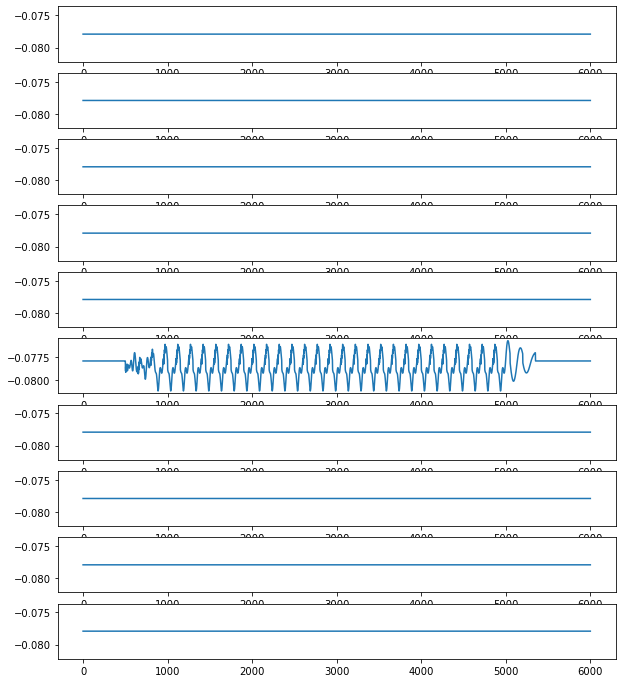

In [15]:
fig, axs = plt.subplots(nrows=10, figsize = (10,12))
for i in range(10):
    axs[i].plot(test[0,i].cpu().detach().numpy())